# IS 470 Assignment 1: Predicting Customer Churn Using Decision Trees

This assignment will help you understand how machine learning models, specifically decision
trees, are used to solve real-world business problems such as predicting customer churn. You’ll
explore a dataset, build classification models, and evaluate their performance. This foundational
project builds your skills for future assignments and gives you hands-on experience relevant to
careers in data science, analytics, and business intelligence.

In [1]:
# Mounting Google rive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pointbiserialr


In [3]:
# Read data
customer_churn = pd.read_csv('/content/drive/MyDrive/IS470_data/CutomerChurnData.csv')
customer_churn

,cust_id,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,tollfree,equip,callcard,wireless,longmon,tollmon,equipmon,cardmon,wiremon,longten,tollten,equipten,cardten,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,loglong,lninc,custcat,churn
0,C00124,R2,13,44,Y,9,64,E4,5,N,N,2,N,N,Y,N,3.70,0.00,0.0,7.50,0.0,37.45,0.00,0.00,110,0.0,N,N,N,N,N,N,Y,N,N,1.308,4.159,C1,Y
1,C00125,R3,68,52,Y,24,116,E1,29,N,Y,2,Y,N,Y,N,18.15,18.00,0.0,30.25,0.0,1300.60,1247.20,0.00,2150,0.0,N,N,N,N,Y,Y,N,Y,N,2.899,4.754,C3,N
2,C00126,R2,23,30,Y,9,30,E1,2,N,N,4,N,N,N,N,6.30,0.00,0.0,0.00,0.0,157.05,0.00,0.00,0,0.0,N,N,N,N,Y,N,Y,Y,N,1.841,3.401,C3,N
3,C00127,R3,45,22,Y,2,19,E2,4,N,Y,5,N,N,Y,N,10.90,0.00,0.0,8.75,0.0,504.50,0.00,0.00,415,0.0,Y,N,N,Y,N,Y,N,N,Y,2.389,2.944,C2,Y
4,C00128,R3,45,59,Y,7,166,E4,31,N,N,5,Y,N,Y,N,9.75,28.50,0.0,12.00,0.0,449.05,1240.15,0.00,505,0.0,Y,N,N,N,Y,Y,Y,Y,N,2.277,5.112,C3,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C01119,R1,50,43,N,6,27,E3,4,N,N,1,Y,N,Y,N,15.00,45.25,0.0,52.75,0.0,817.85,2320.25,0.00,2645,0.0,N,N,N,N,Y,Y,Y,Y,N,2.708,3.296,C3,N
996,C01120,R1,34,52,Y,2,106,E2,19,N,N,2,Y,N,Y,N,4.95,19.00,0.0,13.50,0.0,153.50,649.35,0.00,430,0.0,N,N,N,Y,Y,N,Y,Y,N,1.599,4.663,C3,N
997,C01121,R1,15,46,Y,17,63,E5,1,N,N,2,Y,Y,N,Y,3.70,16.50,42.5,0.00,33.1,40.55,207.35,547.95,0,475.3,Y,Y,Y,Y,Y,N,Y,Y,Y,1.308,4.143,C4,Y
998,C01122,R1,7,34,N,2,22,E5,5,N,Y,1,N,Y,N,N,4.65,0.00,25.6,0.00,0.0,29.35,0.00,179.10,0,0.0,N,N,N,N,N,N,N,N,N,1.537,3.091,C1,N


## Business Understanding:<br/>
**Customer Churn:** This is a number which represents the percentage of customers who stop using your product or service over a given time.<br/>
**Customer Churn in the Telecommunications Industry:** This would be what percentage of customers stop using your service during any given time<br/><br/>
For the purpose of analysis, we can form this into a binary classification problem by defining two unique states:

*   Churned Customers
*   Retained Customers


In [4]:
customer_churn.keys()

Index(['cust_id', 'region', 'tenure', 'age', 'marital', 'address', 'income',
       'ed', 'employ', 'retire', 'gender', 'reside', 'tollfree', 'equip',
       'callcard', 'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon',
       'wiremon', 'longten', 'tollten', 'equipten', 'cardten', 'wireten',
       'multline', 'voice', 'pager', 'internet', 'callid', 'callwait',
       'forward', 'confer', 'ebill', 'loglong', 'lninc', 'custcat', 'churn'],
      dtype='object')

## Data Understanding
### Definitions
**cust_id:** This is just a unique identifier<br/>
**region:** Area of the country<br/>
**tenure:** The amount of months that a customer has been a customer<br/>
**age:** The age of the customer in years<br/>
**marital:** This appears to be the marital status? Y or N<br/>
**address:** Number of years at current address<br/>
**income:** Annual Income (in thousands of dollars)<br/>
**ed:** Educational level<br/>
**employ:** Number of years employed<br/>
**retire:** Retirement Status<br/>
**gender:** Gender<br/>
**reside:** Number of people in household<br/>
**tollfree:** Whether customer has toll-free service<br/>
**equip:** Whether customer has equipment protection<br/>
**callcard:** Uses calling card service<br/>
**wireless:** Has wireless service<br/>
**longmon:** Long-distance minutes used in last month<br/>
**tollmon:** Toll-free minutes used in last month<br/>
**equipmon:** Equipment charges this month<br/>
**cardmon:** Calling card charges this month<br/>
**wiremon:** Wireless charges this month<br/>
**longten:** Cumulative long-distance usage over tenure<br/>
**tollten:** Cumulative toll-free usage over tenure<br/>
**equipten:** Cumulative equipment charges over tenure<br/>
**cardten:** Cumulative calling card charges over tenure<br/>
**wireten:** Cumulative wireless charges over tenure<br/>
**multline:** Has multiple phone lines<br/>
**voice:** Has voice mail service<br/>
**pager:** Has pager service<br/>
**internet:** Has internet service<br/>
**callid:** Has caller ID<br/>
**callwait:** Has call waiting<br/>
**forward:** Has call forwarding<br/>
**confer:** Has conference calling feature<br/>
**ebill:** Uses electronic billing<br/>
**loglong:** Log-transformed long distance usage<br/>
**lninc:** Log-transformed Income<br/>
**custcat:** Customer cateogory<br/>
**churn:** Whether customer churned



In order to determine how each variable relates to the problem at hand (which is whether or not a customer churned). I am creating the following set of functions.<br/>

*   preprocess_churn_data : This function is needed because the data is not in an operational state. For example things like money might be represented as $4.99 and the system doesn't know how to handle that. so this function cleans that up
*   analyse_churn_correlations : this function is what actually does the analysis. depending on whether the field is numeric or categorical it uses one or another function to determine the correlation with teh control variable (churn) it then outputs the results in order.
<br/>Note, both of these functions where originally created by ChatGPT, however I have studied them and understand what they do.



In [5]:
def preprocess_churn_data(df):
    df_clean = df.copy()

    # Step 1: Convert churn column to binary
    if 'churn' in df_clean.columns:
        df_clean['churn'] = df_clean['churn'].map({'Y': 1, 'N': 0})

    # Step 2: Convert all 'Y'/'N' columns to 1/0
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object' and set(df_clean[col].dropna().unique()) <= {'Y', 'N'}:
            df_clean[col] = df_clean[col].map({'Y': 1, 'N': 0})

    # Step 3: Try converting object columns to numeric where possible
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # Remove symbols and try to convert
            df_clean[col] = df_clean[col].str.replace(r'[\$,K]', '', regex=True)
            try:
                df_clean[col] = pd.to_numeric(df_clean[col])
            except:
                pass  # Leave as is if it can't be converted

    return df_clean


In [6]:
def analyze_churn_correlations(df, target_col='churn', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")

    # Prepare variables
    X = df.drop(columns=[target_col] + exclude_cols)
    y = df[target_col]

    results = []

    for col in X.columns:
        try:
            # Skip all-null columns
            if X[col].isnull().all():
                continue

            # If it's numeric and can be converted
            if pd.api.types.is_numeric_dtype(X[col]):
                corr, p_val = pointbiserialr(X[col].fillna(0), y)
                results.append({
                    'feature': col,
                    'type': 'numeric',
                    'metric': 'point_biserial_corr',
                    'score': abs(corr),
                    'p_value': p_val
                })
            else:
                # Convert to categorical explicitly
                mi = mutual_info_classif(X[[col]].fillna('NA').astype(str), y, discrete_features=True)
                results.append({
                    'feature': col,
                    'type': 'categorical',
                    'metric': 'mutual_info',
                    'score': mi[0],
                    'p_value': None
                })

        except Exception as e:
            print(f"Skipping column {col}: {e}")

    results_df = pd.DataFrame(results)

    if not results_df.empty and 'score' in results_df.columns:
        return results_df.sort_values(by='score', ascending=False).reset_index(drop=True)
    else:
        raise ValueError("No valid features found. Please check your data types and column names.")


Now we actually use this function to determine the relationships

In [7]:

# Step 1: Preprocess your data
df_clean = preprocess_churn_data(customer_churn)

# Step 2: Run correlation analysis
exclude_cols = ['cust_id']  # Add any other irrelevant ID columns
result = analyze_churn_correlations(df_clean, target_col='churn', exclude_cols=exclude_cols)

# Step 3: View the results
print(result)




Skipping column region: could not convert string to float: 'R2'
Skipping column ed: could not convert string to float: 'E4'
Skipping column custcat: could not convert string to float: 'C1'
     feature     type               metric     score       p_value
0     tenure  numeric  point_biserial_corr  0.373287  2.031174e-34
1    loglong  numeric  point_biserial_corr  0.323931  7.319137e-26
2   internet  numeric  point_biserial_corr  0.310136  9.784239e-24
3      equip  numeric  point_biserial_corr  0.267653  7.246184e-18
4     employ  numeric  point_biserial_corr  0.263677  2.285789e-17
5    longten  numeric  point_biserial_corr  0.256774  1.604942e-16
6    longmon  numeric  point_biserial_corr  0.251933  6.083048e-16
7   callcard  numeric  point_biserial_corr  0.241241  1.044913e-14
8    cardten  numeric  point_biserial_corr  0.234727  5.531369e-14
9        age  numeric  point_biserial_corr  0.229835  1.871681e-13
10     ebill  numeric  point_biserial_corr  0.229782  1.896224e-13
11  equ

Note, the above list is in order of importance, with the score value being how close the variable tracks with the churn parameter.  This is how we are doing the following charts and graphs

Note, for some reason the fields: region, ed, and custcat were all not processible so I would like to take a quick look at those first to see if there is anything we can learn about them

In [16]:
customer_churn[['region','ed','custcat']].describe()

,region,ed,custcat
count,1000,1000,1000
unique,3,5,4
top,R3,E2,C3
freq,346,290,290


Nothing in particular odd, lets take a closer look

In [21]:
customer_churn['region'].value_counts()

,count
region,
R3,346
R2,338
R1,316


In [22]:
customer_churn['ed'].value_counts()

,count
ed,
E2,290
E3,220
E1,218
E4,216
E5,56


In [23]:
customer_churn['custcat'].value_counts()

,count
custcat,
C3,290
C1,254
C4,240
C2,216


Again, not seeing anything in particular odd here, although I do wonder what exactly custcat is for? (my guess is this is a numeric index referencing some other data set).  Next we will start looking at some of the more important values (according to the results of our previous algorithmic inspection of the values)

In [8]:
# Lets get some summary stats for the most important variables (Explore Dataset chart 1)
customer_churn[['tenure', 'loglong']].describe()

,tenure,loglong
count,1000.000000,1000.000000
mean,35.242000,2.149468
std,21.295937,0.716255
min,1.000000,0.049000
25%,16.000000,1.639000
50%,34.500000,2.140000
75%,53.000000,2.629000
max,72.000000,4.605000


Yea, i'm not really sure what this shows us other than the basic shape of the data, that being tenure has a mean around 35, and laglong 2.14. Lets try another...

Text(0.5, 1.0, 'Boxplot age')

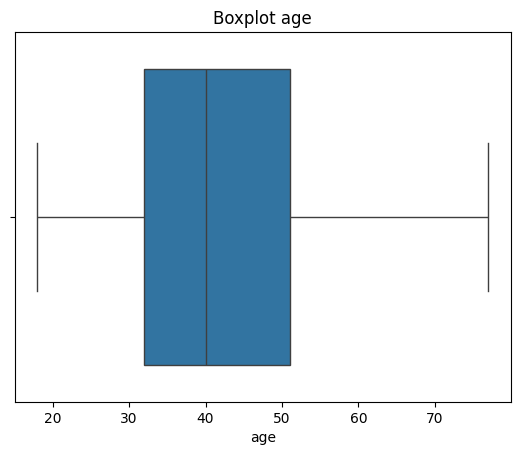

In [9]:
# Boxplot of age (What age is associated with churning?)  (Explore Dataset chart 2)
snsplot = sns.boxplot(x='age', data = customer_churn)
snsplot.set_title('Boxplot age')


Ok, this one might be insightful.  Basically it says that about half the people who churn are between the ages of 32 and 51.  Not sure how interesting that is, but perhaps it says we shouldn't focus on older people (probably becuase they don't change very often so are less likely to churn?)

(0.0, 200.0)

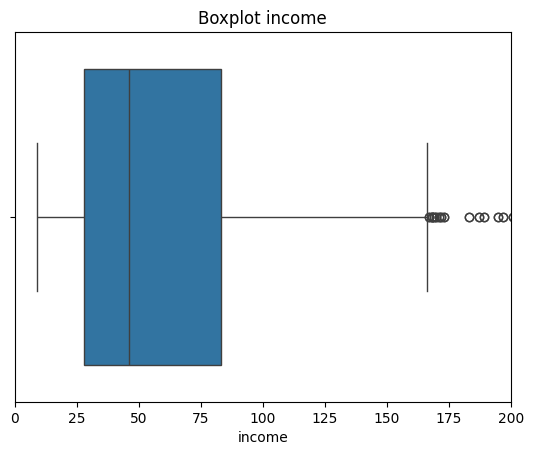

In [10]:
# Boxplot of income                                             (Explore Dataset chart 3)
snsplot = sns.boxplot(x='income', data = customer_churn)
snsplot.set_title('Boxplot income')
snsplot.set_xlim(0, 200)

This one is also interesting, basically people who make between 26k and 81k are the most likely to churn (probably those who make more are not so concerned about their phone bill)

Text(0.5, 1.0, 'Histogram age')

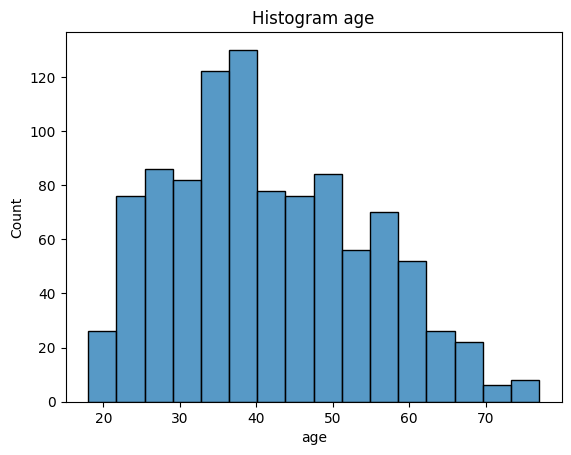

In [25]:
snsplot = sns.histplot(x='age', data = customer_churn)
snsplot.set_title('Histogram age')

Nothing odd here really (what would be odd is having multiple peaks)

Text(0.5, 1.0, 'Scatterplot tenure vs years at current address')

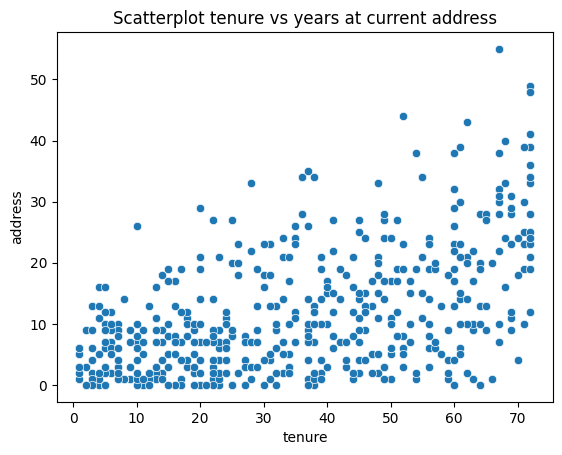

In [30]:
snsplot = sns.scatterplot(x='tenure', y='address', data = customer_churn)
snsplot.set_title('Scatterplot tenure vs years at current address')

ok, it took me several tries to get some numbers that make a graph that actually makes sense.  This particular one seems fairly obvious.  Basically what it is saying is the longer you stay at one address, the longer your tenure is.  While this is true, it also seems to be kind of useless in my opinion.

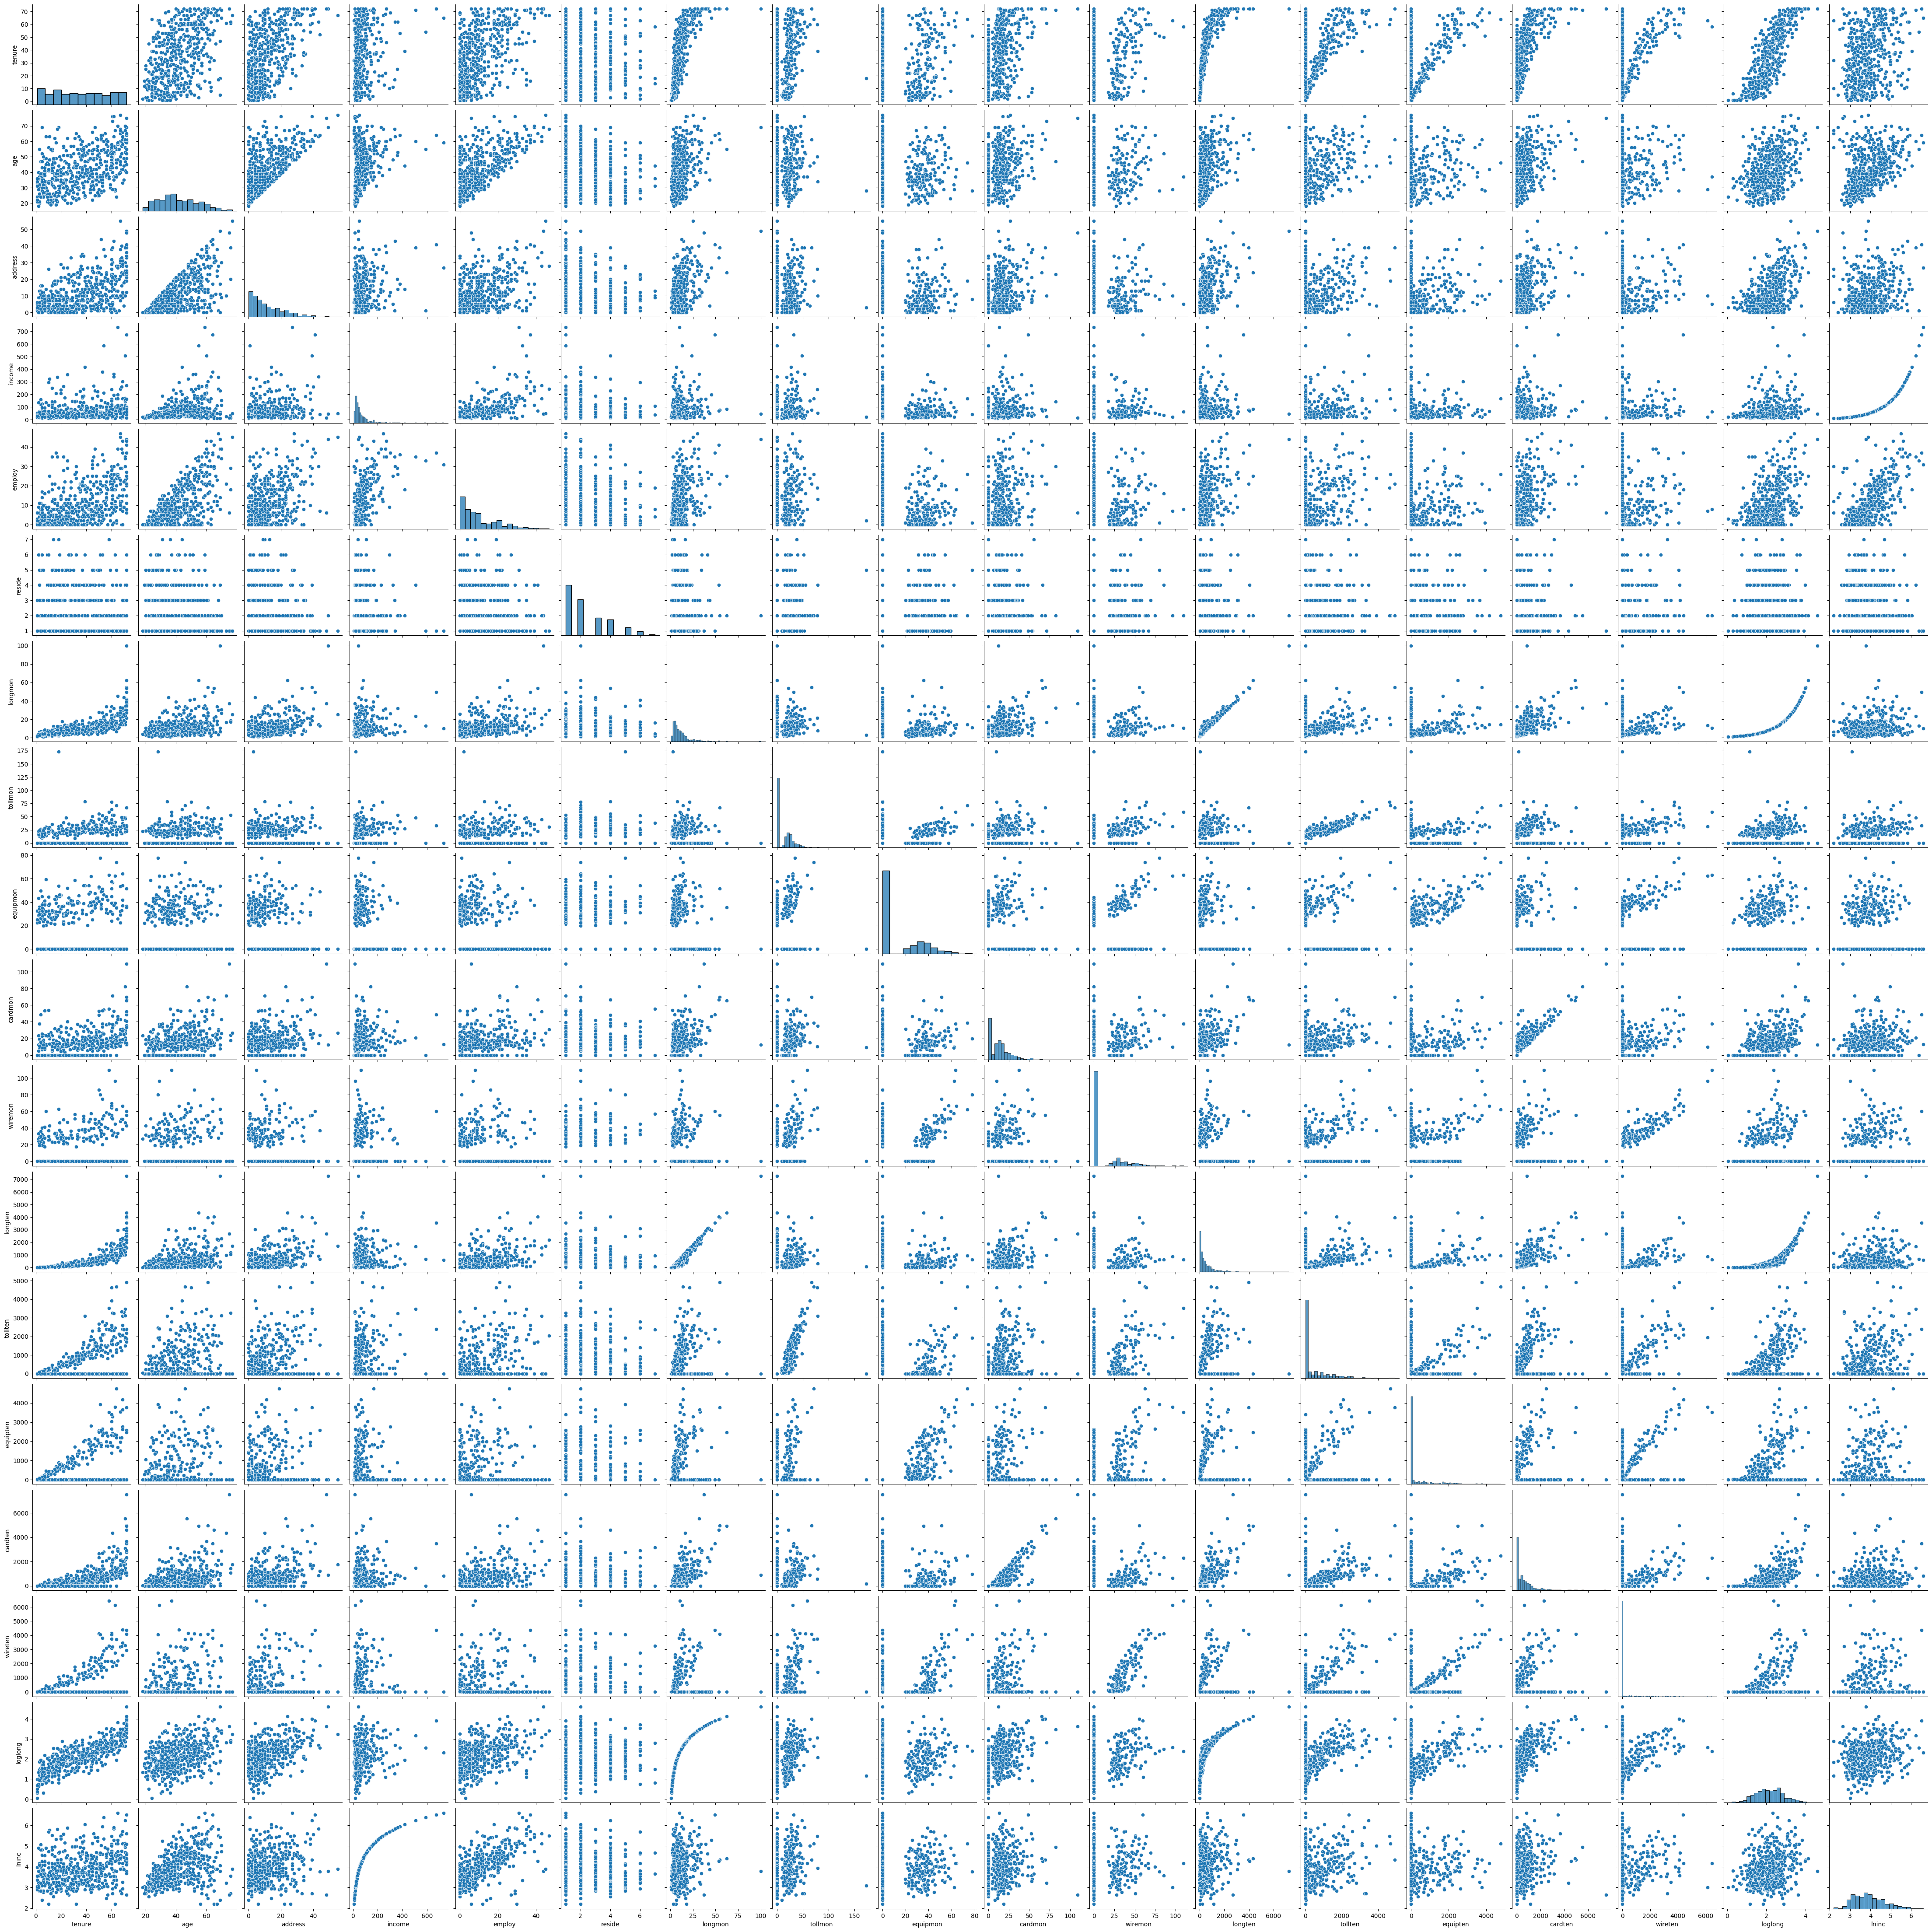

In [31]:
sns.pairplot(data = customer_churn)

Ok, I did this one simply because I wanted to see all the charts.  But after looking at it, I can kinda see why it's done.  By creating this set of charts you can very quickly identify annomolies where you might want to investigate further (which i will do next)